In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import markov_sim as markov
import json
import os
from datetime import datetime
from dateutil import  parser
from hampel import hampel
import time
import copy
import preprocessing as p

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['HSA_OVERRIDE_GFX_VERSION'] = '10.3.0'
os.environ['LD_LIBRARY_PATH'] = '$LD_LIBRARY_PATH:/opt/rocm-5.3.0/lib'
data_list = []


In [72]:
file = '1.145385390.json'

for line in open(file, 'r'):
    data_list.append(json.loads(line))

with open(file, 'r') as f:
    top = f.readline()
    top = json.loads(top)

runner_id = top['mc'][0]['marketDefinition']['runners'][0]['id']
runner_id_2 = top['mc'][0]['marketDefinition']['runners'][1]['id']
market_datetime = parser.parse(data_list[-1]['mc'][0]['marketDefinition']['marketTime'])
r1_result = data_list[-1]['mc'][0]['marketDefinition']['runners'][0]['status']
market_timestamp = datetime.timestamp(market_datetime) * 1000


def get_list(runner_id):
    # Create list for each runner
    runner_list = []
    for instance in data_list:
        if instance['pt'] > market_timestamp:
            if instance['mc'][0]['rc']:
                # Check for runner id
                temp_dict = {k: v for (k, v) in instance['mc'][0]['rc'][0].items() if v == runner_id}
                if temp_dict:
                    # Append runner info
                    runner_list.append([instance['mc'][0]['rc'][0], instance['pt']])
                elif len(instance['mc'][0]['rc']) > 1:
                    # If more than one runner
                    temp_dict_2 = {k: v for (k, v) in instance['mc'][0]['rc'][1].items() if v == runner_id}
                    if temp_dict_2:
                        runner_list.append([instance['mc'][0]['rc'][1], instance['pt']])
    return runner_list


def convert_odds(runner_list):
    # Convert to back/lay/last traded odds

    list = []

    for item in runner_list:
        if 'ltp' in item[0]:
            list.append([item[0]['ltp'], item[1]])

    del list[-1]
    arr = np.array(list)
    arr = arr[arr[:, 0] != 0]
    implied_odds = np.array([1 / arr[:, 0], arr[:, 1]]).T

    return implied_odds


# Find avg ltp odds
def odds_avg(runner_1, runner_2):
    if runner_1[-1, 1] > runner_2[-1, 1]:
        if runner_1[1, 1] > runner_2[1, 1]:
            timestamps = np.arange(round(runner_2[1, 1], -2), round(runner_1[-1, 1] + 1, -2), 100)
        else:
            timestamps = np.arange(round(runner_1[1, 1], -2), round(runner_1[-1, 1] + 1, -2), 100)
    else:
        if runner_1[1, 1] > runner_2[1, 1]:
            timestamps = np.arange(round(runner_2[1, 1], -2), round(runner_2[-1, 1] + 1, -2), 100)
        else:
            timestamps = np.arange(round(runner_1[1, 1], -2), round(runner_2[-1, 1] + 1, -2), 100)

    odds = np.zeros(np.shape(timestamps))
    df_timestamps = pd.Series(timestamps)

    df_datetime = pd.to_datetime(df_timestamps, unit='ms')

    df = pd.DataFrame({'runner 1': odds, '1 - runner 2': odds}, index=df_datetime)

    for index, time in enumerate(runner_1[:, 1]):
        df['runner 1'].loc[pd.to_datetime(round(time, -2), unit='ms')] = runner_1[index, 0]

    for index, time in enumerate(runner_2[:, 1]):
        df['1 - runner 2'].loc[pd.to_datetime(round(time, -2), unit='ms')] = 1 - runner_2[index, 0]

    df.replace(0, np.nan, inplace=True)
    df.interpolate(method='time', limit_direction='both', inplace=True)
    df['avg'] = df.mean(axis=1)
    df_avg_odds = df.resample('1000ms').last()
    last_index = df_avg_odds.last_valid_index() + pd.Timedelta(1, 'sec')
    final_index = last_index + pd.Timedelta(59, 'sec')
    df_datetime = pd.date_range(last_index, final_index, freq='1000ms')
    if r1_result == 'WINNER':
        df_ones = pd.DataFrame({'runner 1': np.ones(60), '1 - runner 2': np.ones(60), 'avg': np.ones(60)}, index=df_datetime)
        df_avg_odds = pd.concat([df_avg_odds, df_ones])
    else:
        df_zeros = pd.DataFrame({'runner 1': np.zeros(60), '1 - runner 2': np.zeros(60), 'avg': np.zeros(60)}, index=df_datetime)
        df_avg_odds = pd.concat([df_avg_odds, df_zeros])
    print(df_avg_odds)
    return df_avg_odds

def get_best_pricevol(runner_list, price, vol):
# Function to get best lay and back information
    back_list = []
    lay_list = []

    back_vol = []
    lay_vol = []

    for item in runner_list:
        if 'atl' in item[0]:
            if len(item[0]['atl']) > 1:
                temp = []
                for i in item[0]['atl']:
                    if i[1] != 0:
                        temp.append(i[0])
                if temp:
                    temp = np.array(temp)
                    back_list.append([temp.min(), item[1]])
                    back_vol.append([item[0]['atl'][temp.argmax()][1], item[1]])
            else:
                if item[0]['atl'][0][1] != 0:
                    back_list.append([item[0]['atl'][0][0], item[1]])
                    back_vol.append([item[0]['atl'][0][1], item[1]])

    for item in runner_list:
        if 'atb' in item[0]:
            if len(item[0]['atb']) > 1:
                temp = []
                for i in item[0]['atb']:
                    if i[1] != 0:
                        temp.append(i[0])
                if temp:
                    temp = np.array(temp)
                    lay_list.append([temp.max(), item[1]])
                    lay_vol.append([item[0]['atb'][temp.argmax()][1], item[1]])
            else:
                if item[0]['atb'][0][1] != 0:
                    lay_list.append([item[0]['atb'][0][0], item[1]])
                    lay_vol.append([item[0]['atb'][0][1], item[1]])

    del back_list[-1], lay_list[-1], back_vol[-1], lay_vol[-1]

    back_vol_arr = np.array(back_vol)
    lay_vol_arr = np.array(lay_vol)
    back_arr = np.array(back_list)
    lay_arr = np.array(lay_list)

    back_series = pd.Series(back_arr[:, 0], index=pd.to_datetime(back_arr[:, 1], unit='ms'))
    lay_series = pd.Series(lay_arr[:, 0], index=pd.to_datetime(lay_arr[:, 1], unit='ms'))
    back_vol_series = pd.Series(back_vol_arr[:, 0], index=pd.to_datetime(back_vol_arr[:, 1], unit='ms'))
    lay_vol_series = pd.Series(lay_vol_arr[:, 0], index=pd.to_datetime(lay_vol_arr[:, 1], unit='ms'))
# Apply hampel filter to remove outliers
    back_outliers = hampel(back_series, window_size=80)
    lay_outliers = hampel(lay_series, window_size=80)
    back_vol_outliers = hampel(back_vol_series, window_size=15)
    lay_vol_outliers = hampel(lay_vol_series, window_size=15)

    back_arr = np.delete(back_arr, back_outliers, axis=0)
    lay_arr = np.delete(lay_arr, lay_outliers, axis=0)
    back_vol_arr = np.delete(back_vol_arr, back_vol_outliers, axis=0)
    lay_vol_arr = np.delete(lay_vol_arr, lay_vol_outliers, axis=0)

    if price and not vol:
        return back_arr, lay_arr
    elif vol and not price:
        return back_vol_arr, lay_vol_arr

    return back_arr, lay_arr, back_vol_arr, lay_vol_arr

def best_available_df(runner_list, start, end):
# Get back and lay information and calculate spread and price up probability
    end_time = end + pd.Timedelta(60, 'sec')
    df_datetime = pd.date_range(start, end_time, freq='100ms')
    df_datetime = df_datetime.floor('100ms')
    dt_shape = np.zeros(df_datetime.shape)

    back_arr, lay_arr, back_vol_arr, lay_vol_arr = get_best_pricevol(runner_list, True, True)

    df = pd.DataFrame({'back': dt_shape, 'lay': dt_shape, 'back_vol': dt_shape, 'lay_vol': dt_shape}, index=df_datetime)

    for index, time in enumerate(back_arr[:, 1]):
        df['back'].loc[pd.to_datetime(round(time, -2), unit='ms')] = back_arr[index, 0]
    for index, time in enumerate(lay_arr[:, 1]):
        df['lay'].loc[pd.to_datetime(round(time, -2), unit='ms')] = lay_arr[index, 0]

    for index, time in enumerate(back_vol_arr[:, 1]):
        df['back_vol'].loc[pd.to_datetime(round(time, -2), unit='ms')] = back_vol_arr[index, 0]
    for index, time in enumerate(lay_vol_arr[:, 1]):
        df['lay_vol'].loc[pd.to_datetime(round(time, -2), unit='ms')] = lay_vol_arr[index, 0]

    df.replace(0, np.nan, inplace=True)
    df.interpolate(method='time', limit_direction='both', inplace=True)

    _1000ms = df.index.floor('1000ms')
    idx_back = df.groupby(_1000ms)['back'].idxmin()
    idx_lay = df.groupby(_1000ms)['lay'].idxmax()
    print(idx_back)
    df = df.resample('1000ms').mean().assign(back=df.loc[idx_back]['back'].values,
                                            back_vol=df.loc[idx_back]['back_vol'].values,
                                            lay=df.loc[idx_lay]['lay'].values,
                                            lay_vol=df.loc[idx_lay]['lay_vol'].values)

    df = df.rolling('60S').mean()
    last_index = df.last_valid_index() + pd.Timedelta(1, 'sec')
    final_index = last_index + pd.Timedelta(59, 'sec')
    df_datetime = pd.date_range(last_index, final_index, freq='1000ms')
    if r1_result == 'WINNER':
        df_ones = pd.DataFrame({'back': np.repeat(1000, 60), 'lay': np.repeat(1000, 60), 'back_vol': np.zeros(60), 'lay_vol': np.zeros(60)}, index=df_datetime)
        df = pd.concat([df, df_ones])
    else:
        df_zeros = pd.DataFrame({'back': np.ones(60), 'lay': np.ones(60), 'back_vol': np.zeros(60), 'lay_vol': np.zeros(60)}, index=df_datetime)
        df = pd.concat([df, df_zeros])
    df = df.loc[start:end]
    df['back-lay avg'] = df[['back', 'lay']].mean(axis=1)
    df['spread'] = df['back'] - df['lay']
    df['vol diff'] = df['back_vol'] - df['lay_vol']
    df['uncertainty'] = df['spread'] / df['back-lay avg']
    df_pup = df['back_vol'] / ( df['back_vol'] + df['lay_vol'] )
    df_pup.name = 'pup'
    df = pd.concat([df, df_pup], axis=1)
    df.fillna(method='ffill', inplace=True)

    return df

def get_serve_prob(first_odds):
    df = pd.read_csv('markov_serve_prob.csv', index_col=0)
    difference = np.absolute(df.index.to_numpy() - first_odds)
    index = difference.argmin()
    r1 = df.iloc[index]
    r2 = 1.29 - r1
    return r1, r2

def get_score_time_series(p, q, df_odds):

    setscore = '0-0'
    gamescore = '0-0'

    r1_gamescore = []
    r1_setscore = []
    r2_gamescore = []
    r2_setscore = []

    odds_arr = df_odds.to_numpy()
    set_trans = markov.set_nextscore()
    match_trans = markov.match_nextscore()
    mis, sis, gis, tbis = initiate_markov_states()

    for odds in odds_arr:
        setscore, gamescore = calc_score(p, q, setscore, gamescore, odds, set_trans, match_trans, mis, sis, gis, tbis)
        r1_gamescore.append(gamescore.split('-')[0])
        r2_gamescore.append(gamescore.split('-')[1])
        r1_setscore.append(setscore.split('-')[0])
        r2_setscore.append(setscore.split('-')[1])
        if r1_setscore[-1] == 3 or r2_setscore[-1] == 3:
            break

    df = pd.DataFrame({'r1_gs': r1_gamescore, 'r2_gs': r2_gamescore, 'r1_setscore': r1_setscore, 'r2_setscore': r2_setscore}, index=df_odds.index)

    return df


def initiate_markov_states():
    matrix = np.zeros((1, 17))
    game_initial_state = pd.DataFrame(data=matrix, columns=markov.col_row_names)
    game_initial_state.at[0, "0-0"] = 1
    matrix = np.zeros((1, 54))
    tb_initial_state = pd.DataFrame(data=matrix, columns=markov.col_row_names2)
    tb_initial_state.at[0, "0-0"] = 1
    matrix = np.zeros((1, 41))
    set_initial_sate = pd.DataFrame(data=matrix, columns=markov.col_row_names3)
    set_initial_sate.at[0, "0-0"] = 1
    matrix = np.zeros((1, 17))
    match_initial_state = pd.DataFrame(data=matrix, columns=markov.col_row_names4)
    match_initial_state.at[0, "0-0"] = 1

    return match_initial_state, set_initial_sate, game_initial_state, tb_initial_state


def set_nextscore(set_transitions, score, winner):
    next_score = set_transitions.columns[(set_transitions == winner).loc[score]]
    return next_score[0]


def match_nextscore(match_transitions, score, winner):
    next_score = match_transitions.columns[(match_transitions == winner).loc[score]]
    return next_score[0]


def calc_score(p, q, setscore, gamescore, implied_odds, set_transitions, match_transitions, mis, sis, gis, tbis):

    nextsetv1 = set_nextscore(set_transitions, gamescore, 1)
    nextsetv2 = set_nextscore(set_transitions, gamescore, -1)
    nextmatchv1 = match_nextscore(match_transitions, setscore, 1)
    nextmatchv2 = match_nextscore(match_transitions, setscore, -1)

    if nextsetv1 == 'SETv1' and nextsetv2 == 'SETv2':
        nextsetv1 = '0-0'
        nextsetv2 = '0-0'
    elif nextsetv1 == 'SETv1':
        nextsetv1 = '0-0'
        nextmatchv2 = setscore
    elif nextsetv2 == 'SETv2':
        nextsetv2 = '0-0'
        nextmatchv1 = setscore
    else:
        nextmatchv1 = setscore
        nextmatchv2 = setscore

    mis1 = mis.copy()
    sis1 = sis.copy()
    gis1 = gis.copy()
    tbis1 = tbis.copy()
    mis2 = mis.copy()
    sis2 = sis.copy()
    gis2 = gis.copy()
    tbis2 = tbis.copy()

    if nextmatchv1 == ('3-2') and nextmatchv2 == ('2-3'):
        m1 = 1
        m2 = 0
    elif nextmatchv1 == '3-2' or nextmatchv1 == '3-1' or nextmatchv1 == '3-0':
        m1 = 1
        m2 = markov.tennis_model(p, q, nextmatchv2, nextsetv2, mis2, sis2, gis2, tbis2)['r1_win'].values
    elif nextmatchv2 == '2-3' or nextmatchv2 == '1-3' or nextmatchv2 == '0-3':
        m1 = markov.tennis_model(p, q, nextmatchv1, nextsetv1, mis1, sis1, gis1, tbis1)['r1_win'].values
        m2 = 0
    else:
        m1 = markov.tennis_model(p, q, nextmatchv1, nextsetv1, mis1, sis1, gis1, tbis1)['r1_win'].values
        m2 = markov.tennis_model(p, q, nextmatchv2, nextsetv2, mis2, sis2, gis2, tbis2)['r1_win'].values

    if implied_odds >= m1:
        gamescore = nextsetv1
        setscore = nextmatchv1
    elif implied_odds <= m2:
        gamescore = nextsetv2
        setscore = nextmatchv2

    return setscore, gamescore



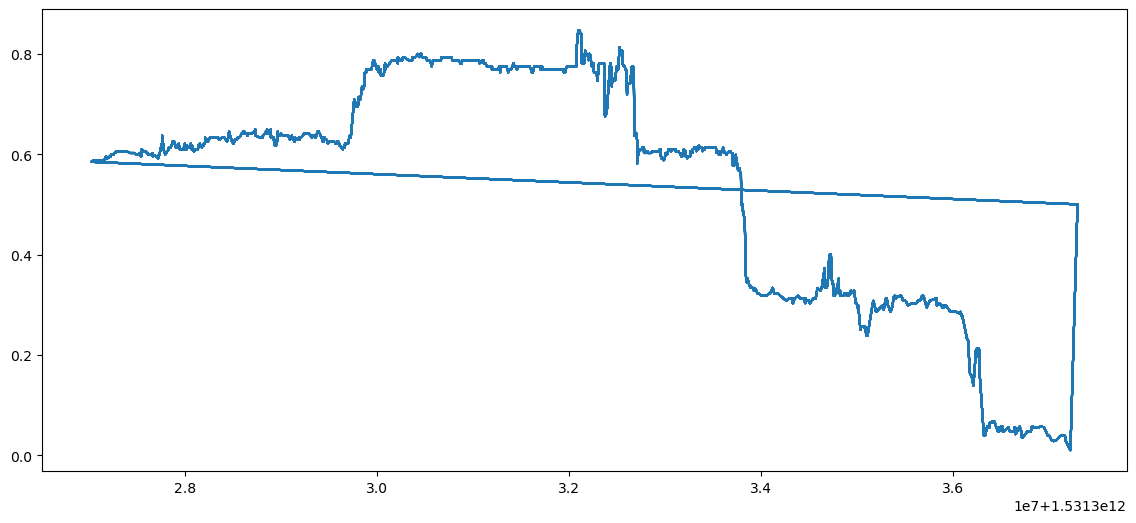

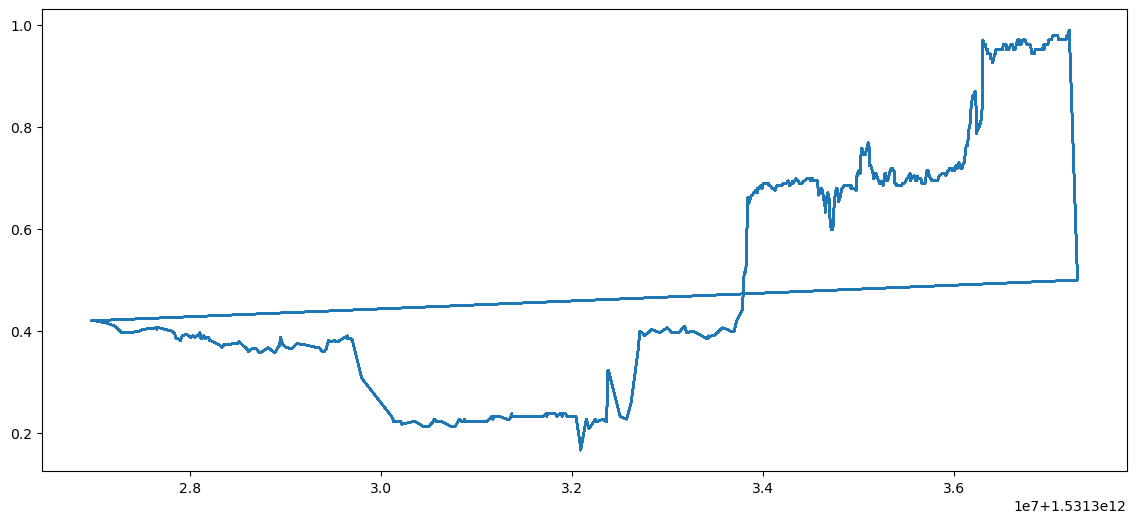

In [67]:
runner_list_1 = get_list(runner_id)
runner_list_2 = get_list(runner_id_2)
runner_odds_1 = convert_odds(runner_list_1)
runner_odds_2 = convert_odds(runner_list_2)
plt.figure(figsize=(14,6))
plt.plot(runner_odds_1[:, 1], runner_odds_1[:, 0])
plt.figure(figsize=(14,6))
plt.plot(runner_odds_2[:, 1], runner_odds_2[:, 0])


In [56]:
df = odds_avg(runner_odds_1, runner_odds_2)

                     runner 1  1 - runner 2       avg
2018-07-11 16:36:43  0.584795      0.579832  0.582314
2018-07-11 16:36:44  0.584795      0.579868  0.582332
2018-07-11 16:36:45  0.584795      0.579905  0.582350
2018-07-11 16:36:46  0.584795      0.579942  0.582368
2018-07-11 16:36:47  0.584795      0.579978  0.582387
...                       ...           ...       ...
2018-07-11 19:27:58  0.000000      0.000000  0.000000
2018-07-11 19:27:59  0.000000      0.000000  0.000000
2018-07-11 19:28:00  0.000000      0.000000  0.000000
2018-07-11 19:28:01  0.000000      0.000000  0.000000
2018-07-11 19:28:02  0.000000      0.000000  0.000000

[10280 rows x 3 columns]


0.590545183180802
Serve percentage    0.653
Name: 0.5949573027806575, dtype: float64
Serve percentage    0.637
Name: 0.5949573027806575, dtype: float64


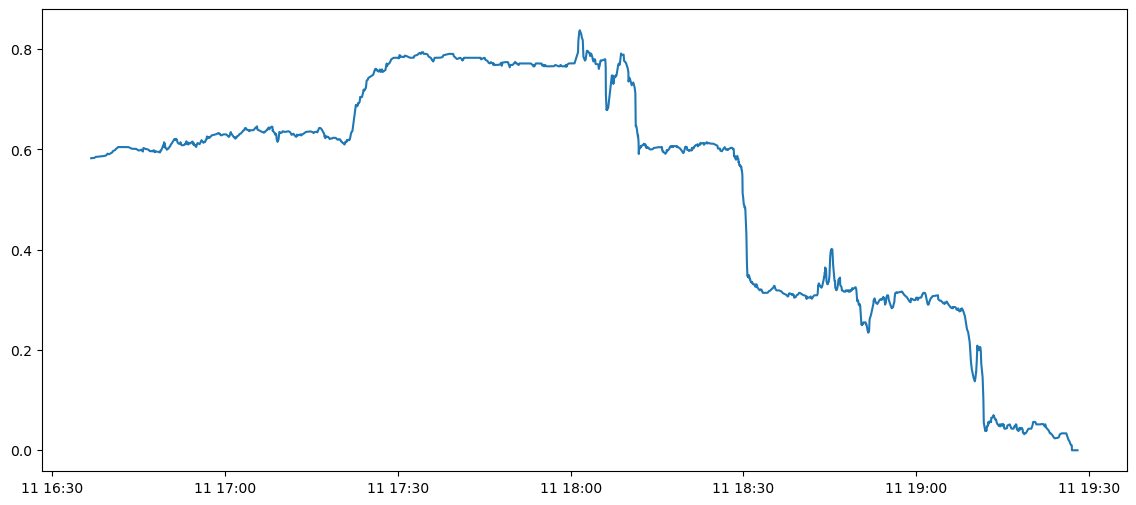

In [58]:
plt.figure(figsize=(14,6))
plt.plot(df['avg'])
first_odds = df['avg'].iloc[0:300].mean()
print(first_odds)
r1, r2 = get_serve_prob(first_odds)
print(r1)
print(r2)

In [73]:
df_score = get_score_time_series(r1, r2, df['avg'])
print(df_score)

IndexError: index 0 is out of bounds for axis 0 with size 0

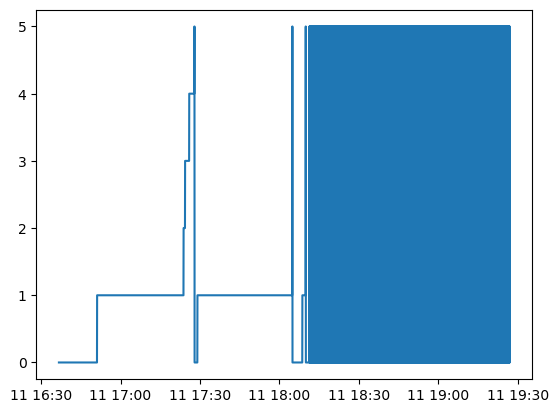

In [22]:
plt.plot(df_score['r1_gs'])

In [49]:
start = df.first_valid_index()
end = df.last_valid_index()
df_runner_1 = best_available_df(runner_list_1, start, end)
print(df_runner_1)

2018-07-11 16:36:43   2018-07-11 16:36:43
2018-07-11 16:36:44   2018-07-11 16:36:44
2018-07-11 16:36:45   2018-07-11 16:36:45
2018-07-11 16:36:46   2018-07-11 16:36:46
2018-07-11 16:36:47   2018-07-11 16:36:47
                              ...        
2018-07-11 19:28:58   2018-07-11 19:28:58
2018-07-11 19:28:59   2018-07-11 19:28:59
2018-07-11 19:29:00   2018-07-11 19:29:00
2018-07-11 19:29:01   2018-07-11 19:29:01
2018-07-11 19:29:02   2018-07-11 19:29:02
Name: back, Length: 10340, dtype: datetime64[ns]
                      back       lay  back_vol      lay_vol  back-lay avg  \
2018-07-11 16:36:43   1.72  1.710000    168.53  2037.760000      1.715000   
2018-07-11 16:36:44   1.72  1.710000    168.53  2037.760000      1.715000   
2018-07-11 16:36:45   1.72  1.710000    168.53  1959.174162      1.715000   
2018-07-11 16:36:46   1.72  1.710000    168.53  1917.817845      1.715000   
2018-07-11 16:36:47   1.72  1.710000    168.53  1891.353337      1.715000   
...                    ... 

In [50]:
df_runner_2 = best_available_df(runner_list_2, start, end)
print(df_runner_2)

2018-07-11 16:36:43   2018-07-11 16:36:43
2018-07-11 16:36:44   2018-07-11 16:36:44
2018-07-11 16:36:45   2018-07-11 16:36:45
2018-07-11 16:36:46   2018-07-11 16:36:46
2018-07-11 16:36:47   2018-07-11 16:36:47
                              ...        
2018-07-11 19:28:58   2018-07-11 19:28:58
2018-07-11 19:28:59   2018-07-11 19:28:59
2018-07-11 19:29:00   2018-07-11 19:29:00
2018-07-11 19:29:01   2018-07-11 19:29:01
2018-07-11 19:29:02   2018-07-11 19:29:02
Name: back, Length: 10340, dtype: datetime64[ns]
                         back       lay     back_vol      lay_vol  \
2018-07-11 16:36:43  2.400000  2.360000     3.000000  1487.840000   
2018-07-11 16:36:44  2.400000  2.360000     3.000000  1487.840000   
2018-07-11 16:36:45  2.400000  2.351667     3.000000  1374.644167   
2018-07-11 16:36:46  2.400000  2.340556     3.000000  1223.716389   
2018-07-11 16:36:47  2.400000  2.328551     3.000000   990.761231   
...                       ...       ...          ...          ...   
2018-0

                     ltp odds  back lay odds
2018-07-11 16:36:43  0.582314       0.581461
2018-07-11 16:36:44  0.582332       0.581461
2018-07-11 16:36:45  0.582350       0.581093
2018-07-11 16:36:46  0.582368       0.580599
2018-07-11 16:36:47  0.582387       0.580064
...                       ...            ...
2018-07-11 19:27:58  0.000000       0.138580
2018-07-11 19:27:59  0.000000       0.140425
2018-07-11 19:28:00  0.000000       0.142252
2018-07-11 19:28:01  0.000000       0.144060
2018-07-11 19:28:02  0.000000       0.145850

[10280 rows x 2 columns]


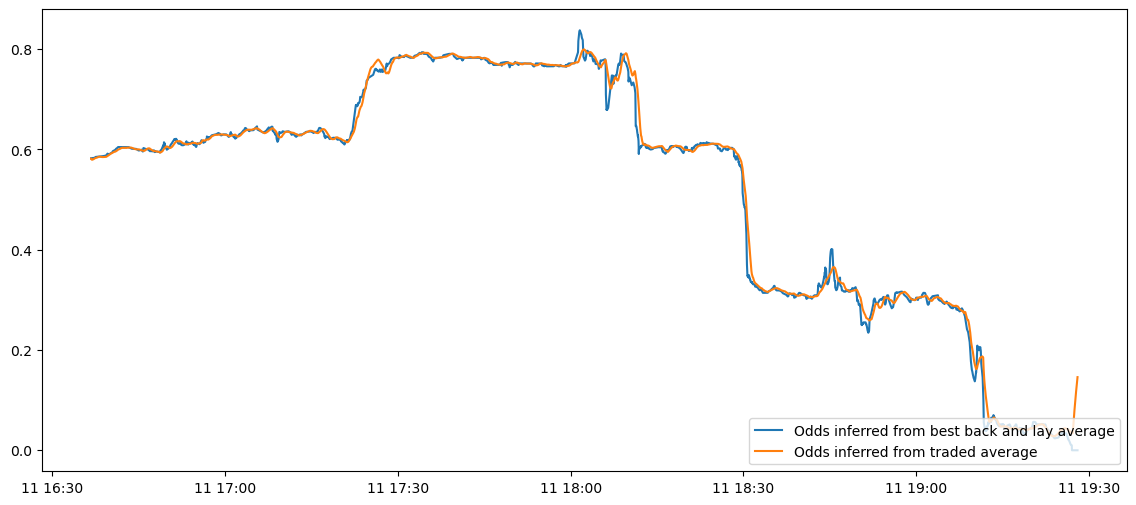

In [52]:
df_avg = df['avg']
df_blodds = ( 1 / df_runner_1['back-lay avg'] + 1 - 1 / df_runner_2['back-lay avg'] ) / 2
df_odds = pd.concat([df_avg, df_blodds], axis=1)
df_odds.columns = ['ltp odds', 'back lay odds']
print(df_odds)
plt.figure(figsize=(14,6))
plt.plot(df_odds)
plt.legend(['Odds inferred from best back and lay average', 'Odds inferred from traded average'], loc='lower right')

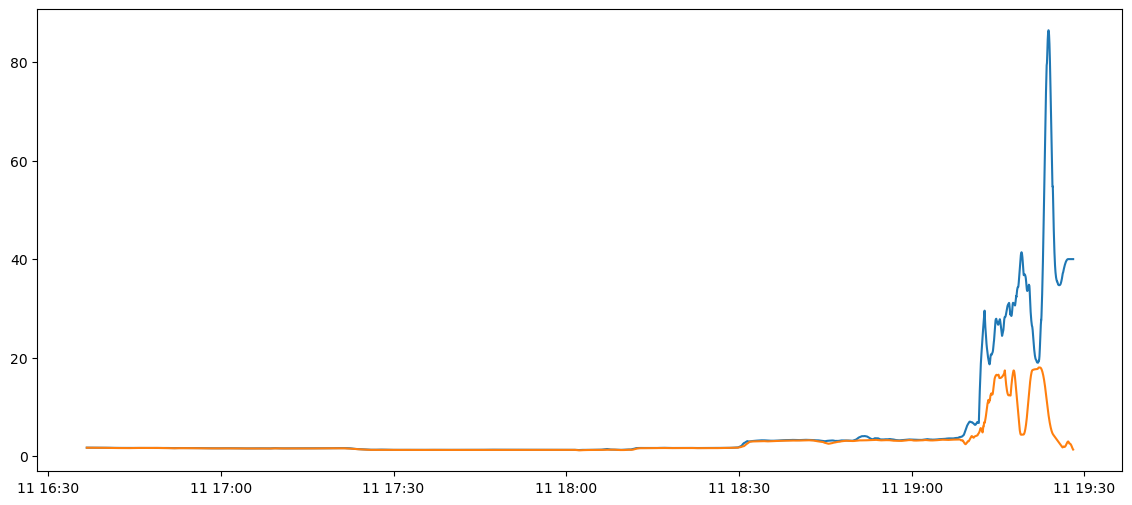

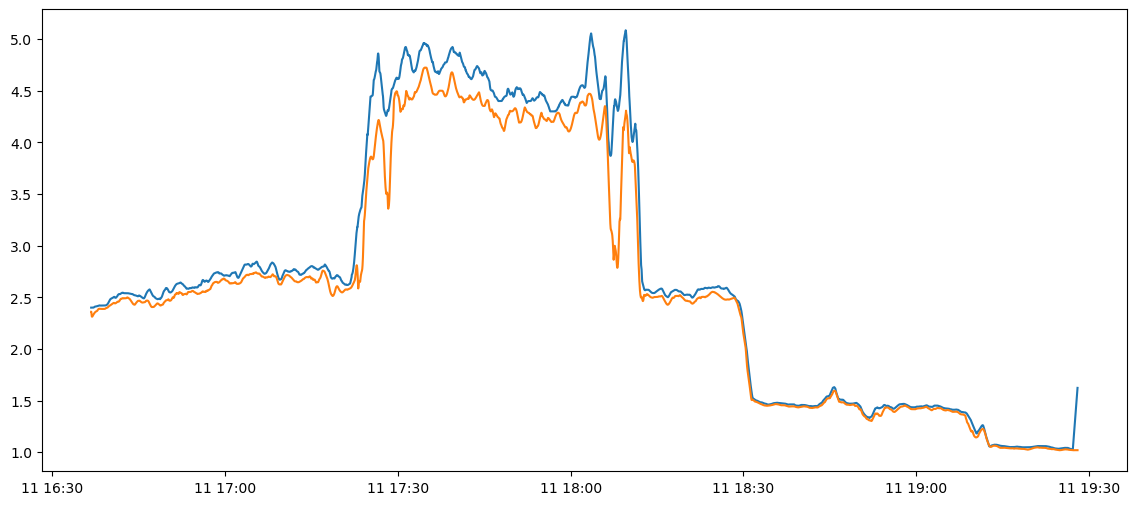

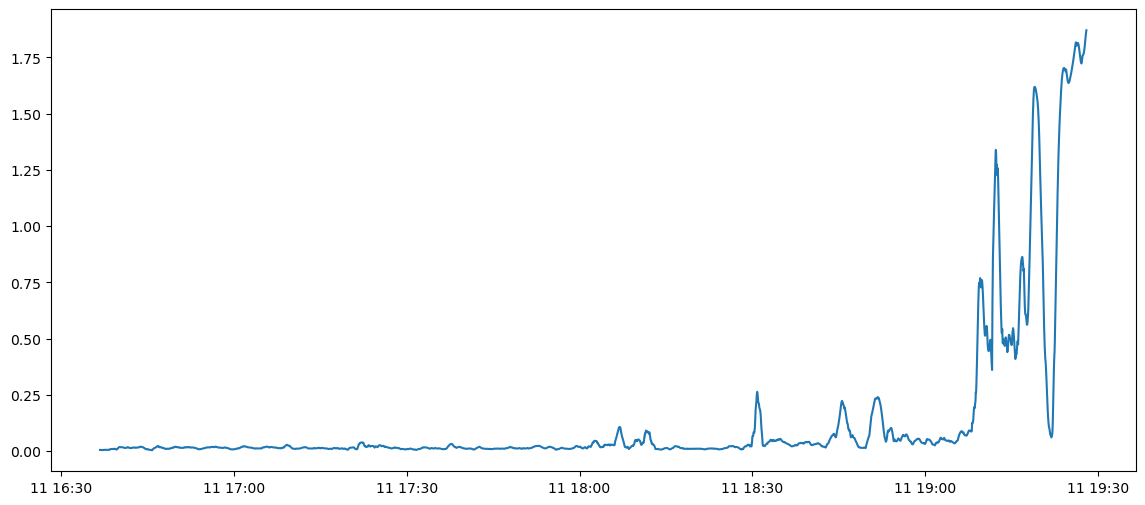

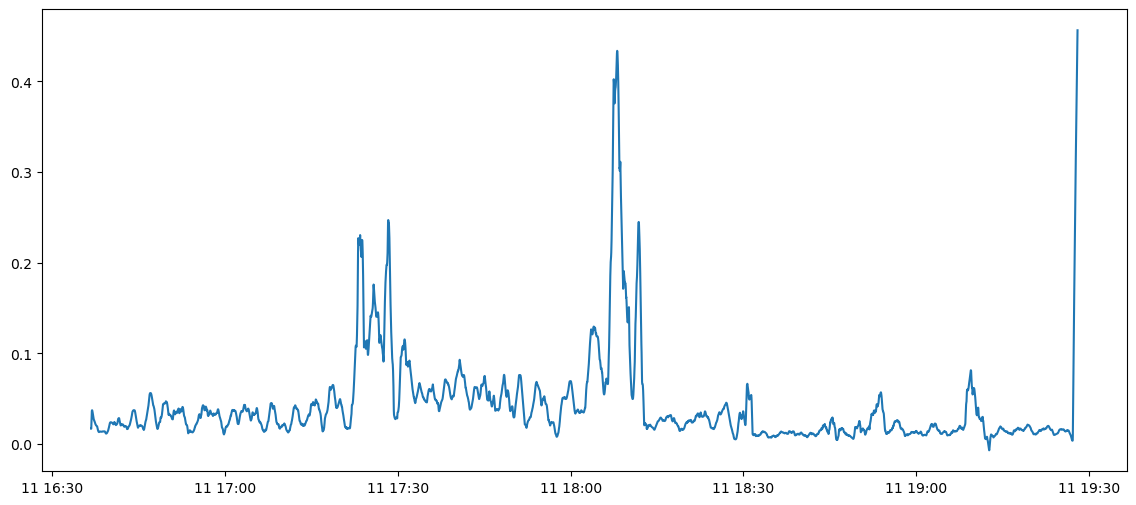

In [53]:
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['back','lay']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['back','lay']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['uncertainty']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['uncertainty']])

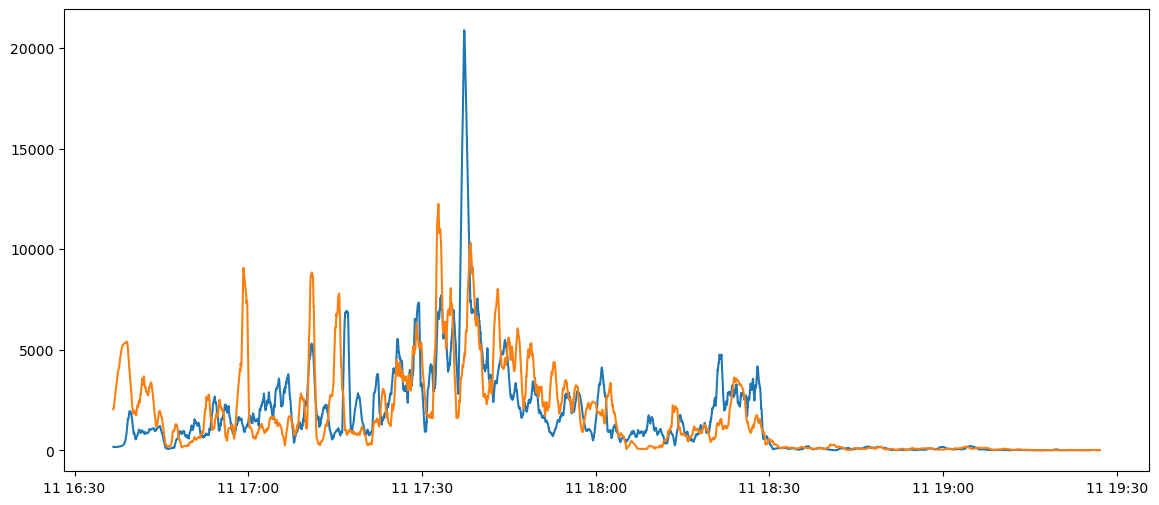

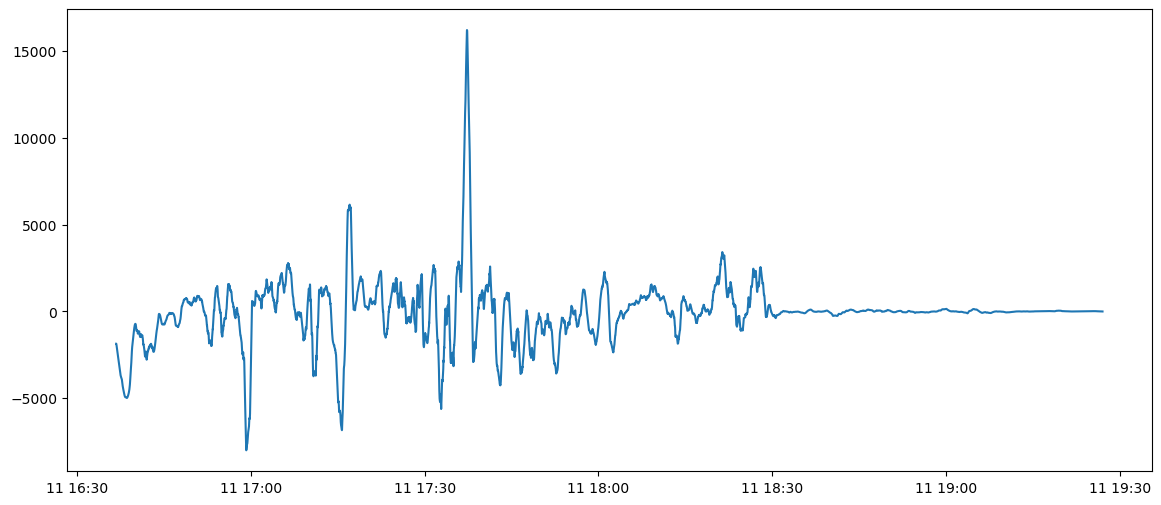

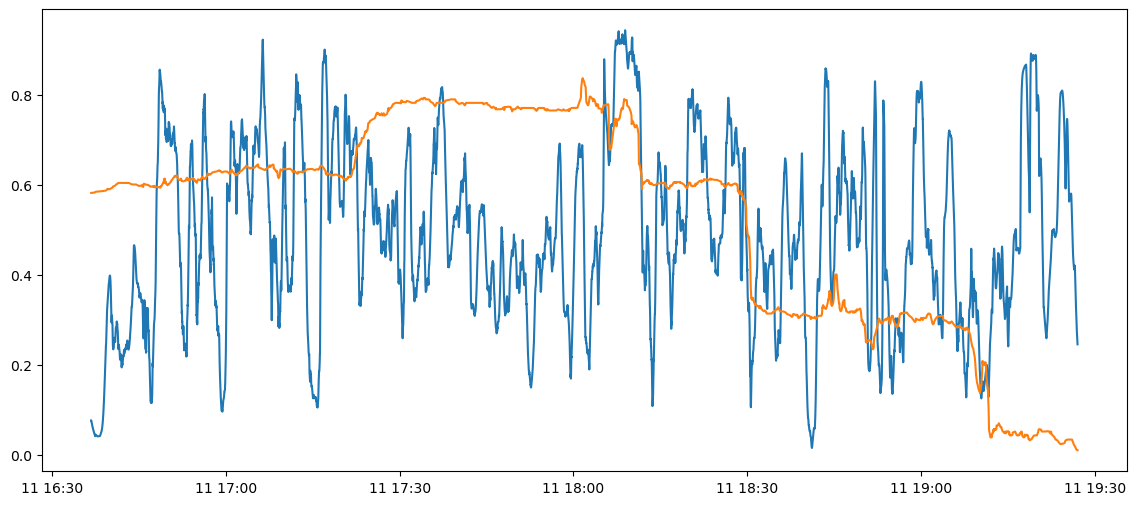

In [48]:
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['back_vol']])
plt.plot(df_runner_1[['lay_vol']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['vol diff']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['pup']])
plt.plot(df_odds['ltp odds'])

                     lpt odds  r1 spread    r1 pup  r2 spread    r2 pup
2018-07-11 16:36:43  0.582314   0.005831  0.076386   0.016807  0.002012
2018-07-11 16:36:44  0.582332   0.005831  0.076386   0.016807  0.002012
2018-07-11 16:36:45  0.582350   0.005831  0.075513   0.020344  0.002178
2018-07-11 16:36:46  0.582368   0.005831  0.074378   0.025079  0.002446
2018-07-11 16:36:47  0.582387   0.005831  0.073169   0.030220  0.003019
...                       ...        ...       ...        ...       ...
2018-07-11 19:26:58  0.010017   1.739036  0.261170   0.012088  0.452541
2018-07-11 19:26:59  0.009950   1.734467  0.256943   0.011863  0.454996
2018-07-11 19:27:00  0.009950   1.729862  0.252935   0.011628  0.459927
2018-07-11 19:27:01  0.009950   1.725221  0.249145   0.011334  0.466941
2018-07-11 19:27:02  0.009950   1.720543  0.245569   0.011082  0.473873

[10220 rows x 5 columns]


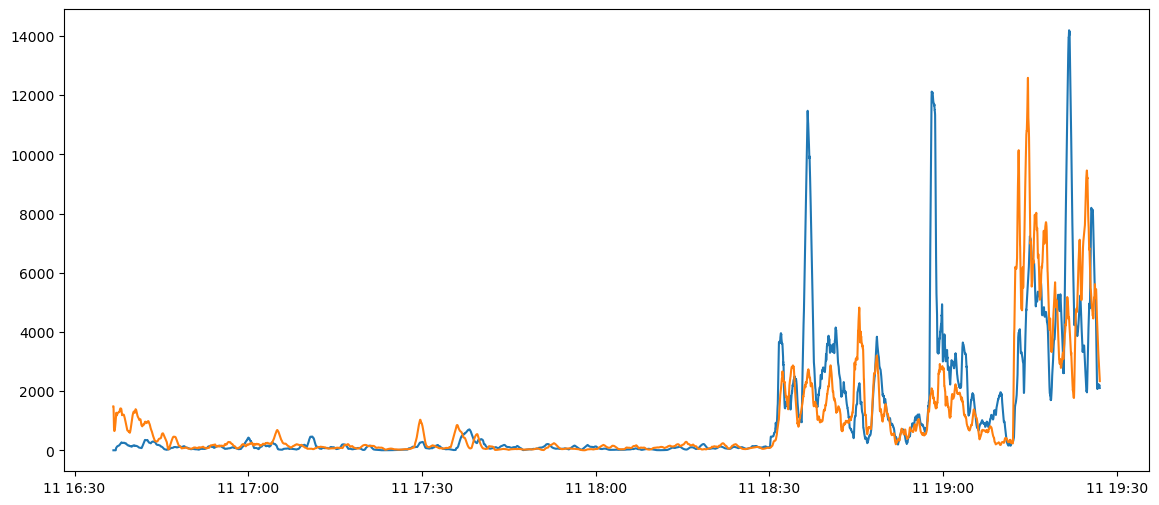

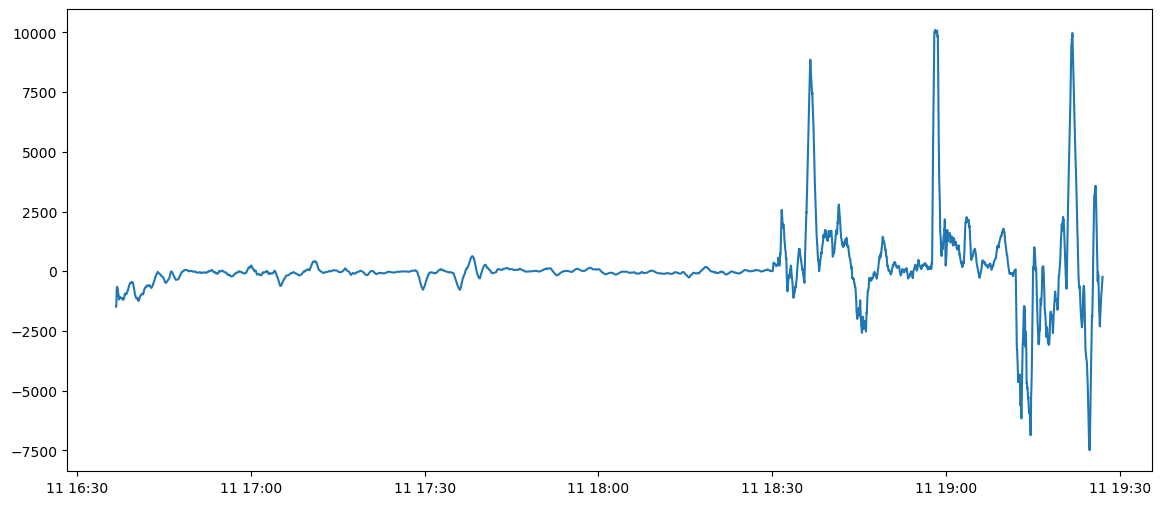

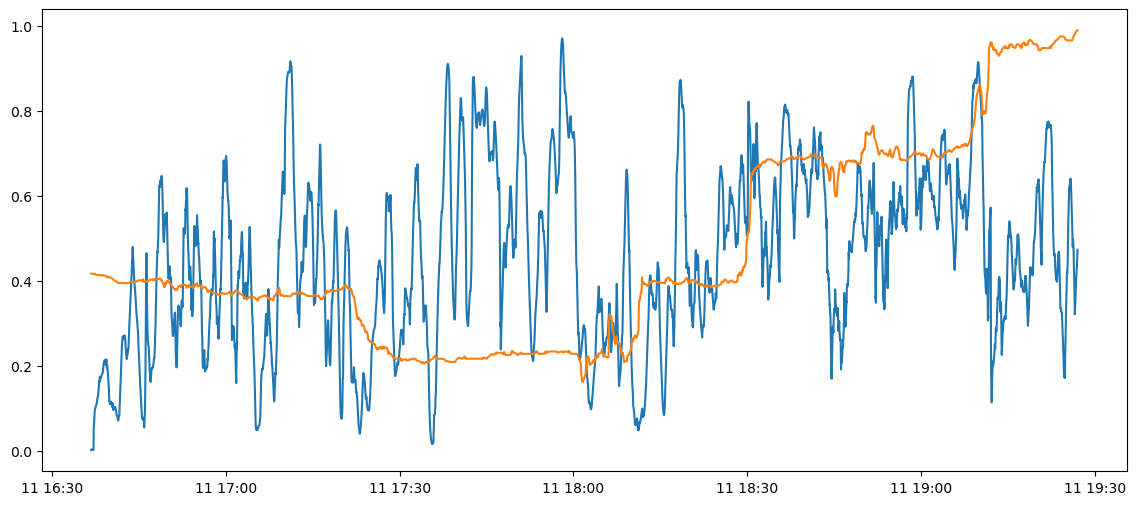

In [49]:
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['back_vol']])
plt.plot(df_runner_2[['lay_vol']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['vol diff']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['pup']])
plt.plot(1 - df_odds['ltp odds'])
df_total = pd.DataFrame({'lpt odds': df_odds['ltp odds'], 'r1 spread': df_runner_1['uncertainty'], 'r1 pup': df_runner_1['pup'], 'r2 spread': df_runner_2['uncertainty'], 'r2 pup': df_runner_2['pup']}, index=df_odds.index)
print(df_total)
df_total.to_csv('Data/1.csv')